In [1]:
import matplotlib.pyplot as plt
from pylab import rcParams

In [2]:
import numpy as np
import pandas as pd
import os

In [3]:
import mne

In [4]:
import pandas as pd

In [5]:
from scipy.io import loadmat

In [6]:
from sklearn.preprocessing import StandardScaler

In [7]:
from sklearn.decomposition import IncrementalPCA

In [8]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

In [9]:
from sklearn.model_selection import GridSearchCV

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

In [11]:
from sklearn.svm import SVC

In [12]:
from sklearn.ensemble import GradientBoostingClassifier

In [13]:
from sklearn.linear_model import LogisticRegression

In [14]:
import plotly.express as px

In [15]:
from sklearn.decomposition import PCA

In [16]:
from scipy.signal import argrelextrema

In [17]:
from scipy.io import loadmat, savemat

In [18]:
from tqdm import tqdm_notebook

In [19]:
MAIN_CHANNELS = ["Fz", "Cz", "P3", "Pz", "P4", "Po7", "Po8", "Oz"]

In [20]:
sfreq = 250

# Preprocess

In [855]:
def load_data(subject):
    channels = MAIN_CHANNELS
    
    session = loadmat('/tmp/{}.mat'.format(subject))

    session_df = pd.DataFrame(session["y"], columns=channels)

    sfreq = session["fs"][0][0]

    session_df["Time"] = session_df.index / session["fs"][0][0]

    session_df["Trigger"] = session["trig"]
    session_df.loc[session_df["Trigger"] == -1, "Trigger"] = 2
    
    return session_df

In [856]:
def restore_raw(session_df):
    channels = MAIN_CHANNELS + ['Trigger']
    info = mne.create_info(ch_names=channels, sfreq=sfreq)

    raw = mne.io.RawArray(session_df[channels].values.T, info)

    channel_types = {c: 'eeg' for c in channels}
    channel_types['Trigger'] = 'stim'

    raw.set_channel_types(channel_types)
    
    return raw

In [857]:
def filter_signal(raw):
    raw.notch_filter(50)
    raw.filter(0.5, 30)

In [858]:
def plot_raw(raw, start=30, stop=50, scale=100):
    rcParams['figure.figsize'] = 15, 10
    mne.viz.plot_raw(
        raw, 
        start=start, 
        duration=stop - start, 
        show=False, 
        n_channels=9,
        scalings={'eeg': scale}
    )
    plt.show()

In [859]:
def scale_signal(raw, session_df):
    channels = MAIN_CHANNELS + ['Trigger']
    
    events = mne.find_events(raw, 'Trigger')
    channels_data = raw.copy().pick_types(eeg=True).get_data()
    training_data = channels_data[:, :events[0][0] - 1]

    trigger_data = session_df["Trigger"].values

    scaler = StandardScaler()
    scaler.fit(training_data.T)
    scaled_channels_data = scaler.transform(channels_data.T).T

    np.mean(scaled_channels_data, axis=1)

    new_channels_data = np.vstack([
        scaled_channels_data,
        trigger_data[np.newaxis, :]
    ])

    raw = mne.io.RawArray(new_channels_data, raw.info)
    
    channel_types = {c: 'eeg' for c in channels}
    channel_types['Trigger'] = 'stim'

    raw.set_channel_types(channel_types)
    
    return raw

In [860]:
def remove_artifacts(raw, n_components=2):
    print("Removing artifacts with {}".format(n_components))
    ica = mne.preprocessing.ICA()

    ica.fit(raw)

    ica_eeg = ica.get_sources(raw)

    plt.figure(figsize=(10, 5))
    plt.plot(ica_eeg[:, :][0].T + 10 * np.arange(0, 8))

    stds = np.std(np.abs(ica_eeg[:, :][0]), axis=1)
    exclude_components = (-stds).argsort()[0:n_components + 1]

    raw = ica.apply(raw.copy(), exclude=list(exclude_components))
    
    return raw

In [861]:
def get_epochs(raw):
    events = mne.find_events(raw, 'Trigger')
    
    epochs = mne.Epochs(
        raw.pick_types(eeg=True), 
        events, tmin=-0.1, tmax=0.7,
#         reject_by_annotation=False,
        preload=True
    )
#     epochs = epochs.apply_baseline((-0.1, 0))
    return epochs

In [862]:
def show_p300_plots(epochs):
    epochs['1'].average().plot()
    plt.show()
    
    epochs['2'].average().plot()
    plt.show()

In [863]:
def process_signal(i, n_components=2):
    subject = "S{}".format(i)
    session_df = load_data(subject)
    raw = restore_raw(session_df)
    plot_raw(raw)
    
    filter_signal(raw)
    plot_raw(raw)
    
    raw = scale_signal(raw, session_df)
    plot_raw(raw, scale=5)
    
#     raw = remove_artifacts(raw, n_components)
    
    epochs = get_epochs(raw)    
#     show_p300_plots(epochs)
    
    return epochs

Creating RawArray with float64 data, n_channels=9, n_times=65502
    Range : 0 ... 65501 =      0.000 ...   262.004 secs
Ready.
The unit for channel(s) Cz, Fz, Oz, P3, P4, Po7, Po8, Pz has changed from NA to V.


<ipython-input-856-90a5503e84bc>:10: RuntimeWarning:

The unit for channel(s) Cz, Fz, Oz, P3, P4, Po7, Po8, Pz has changed from NA to V.



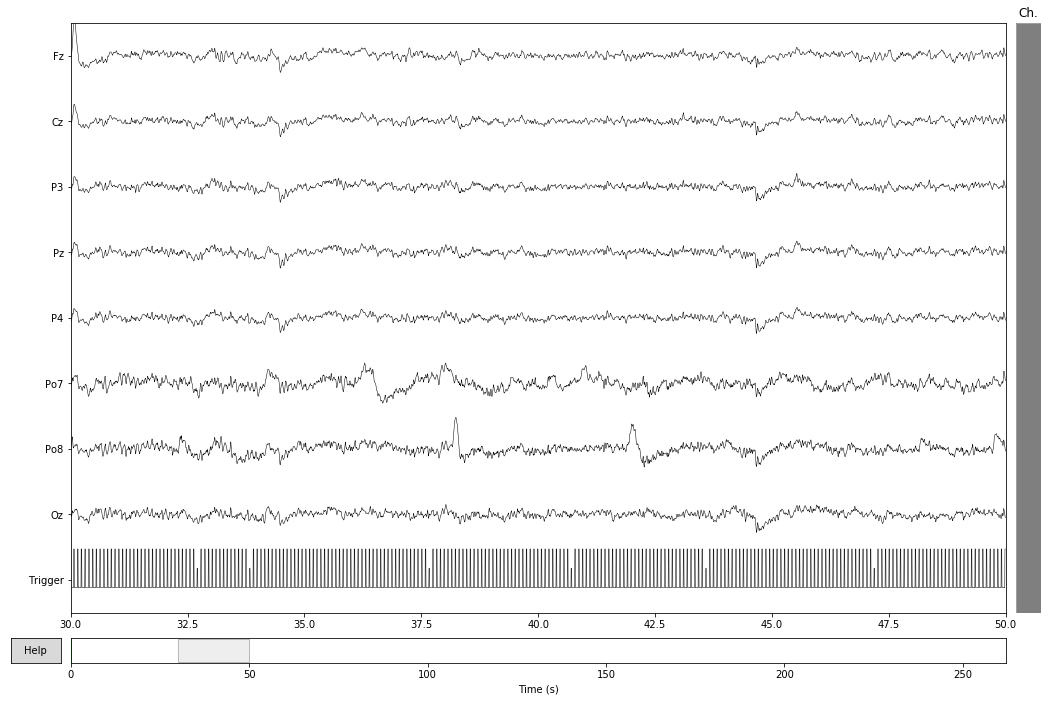

Setting up band-stop filter from 49 - 51 Hz
Filter length of 1651 samples (6.604 sec) selected
Setting up band-pass filter from 0.5 - 30 Hz
l_trans_bandwidth chosen to be 0.5 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 1651 samples (6.604 sec) selected


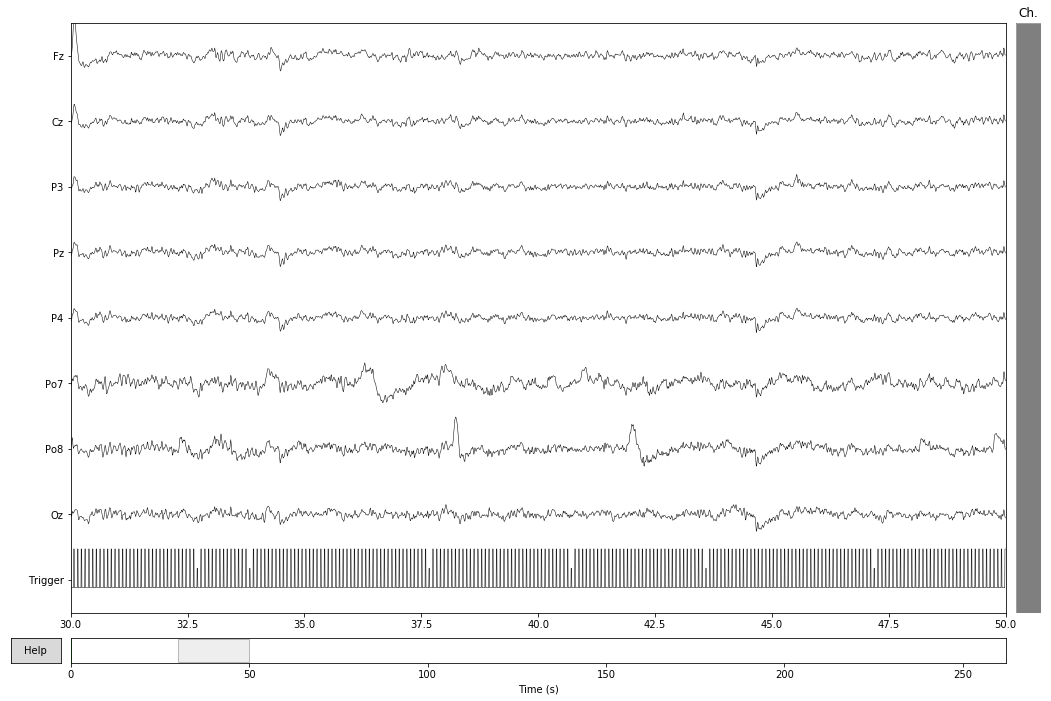

2700 events found
Event IDs: [1 2]
Creating RawArray with float64 data, n_channels=9, n_times=65502
    Range : 0 ... 65501 =      0.000 ...   262.004 secs
Ready.


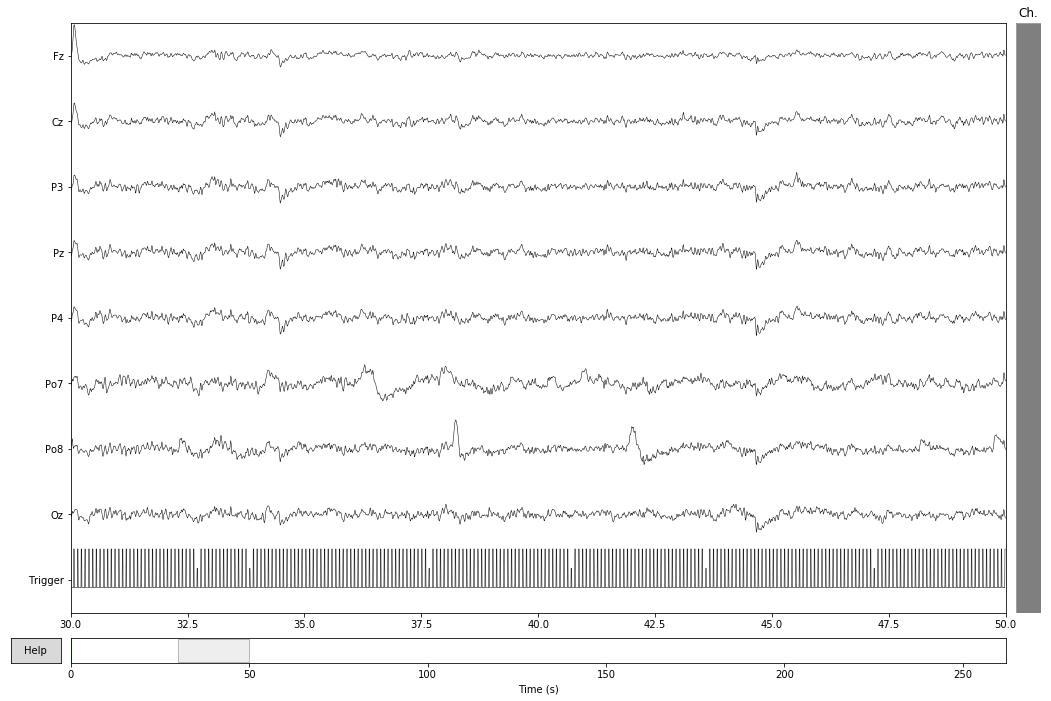

2700 events found
Event IDs: [1 2]
2700 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 2700 events and 201 original time points ...
0 bad epochs dropped


In [1073]:
epochs = process_signal(2)

In [1074]:
ica = mne.preprocessing.ICA()
ica.fit(epochs)

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 8
Fitting ICA took 2.8s.


<ICA  |  epochs decomposition, fit (fastica): 542700 samples, 8 components, channels used: "eeg">

In [1075]:
ica_eeg = ica.get_sources(epochs['1'])

In [1076]:
test_data = ica_eeg.get_data()
test_time = np.linspace(-100, 800, 201)

In [1077]:
def convert_time_to_sample(x):
    return np.argmin(np.abs(test_time - x))

In [1078]:
baseline_start = convert_time_to_sample(-100)
baseline_end = convert_time_to_sample(0)

In [1079]:
baseline_start, baseline_end

(0, 22)

In [1080]:
p300_start = convert_time_to_sample(300)
p300_end = convert_time_to_sample(450)

In [1081]:
p300_start, p300_end

(89, 122)

In [1082]:
baseline_test_data = test_data[:, :, baseline_start:baseline_end]
p300_test_data = test_data[:, :, p300_start:p300_end]

In [1083]:
import seaborn as sns

In [1084]:
from scipy.stats import mannwhitneyu, ttest_ind

In [1085]:
# components = []
# plt.figure(figsize=(10, 20))
# for c in range(0, 8):
#     pvalue = mannwhitneyu(
#         baseline_test_data[:, c, :].reshape(-1) + 0.05, 
#         p300_test_data[:, c, :].reshape(-1),
#         alternative='less'
#     ).pvalue
    
#     color = 'green'
    
#     if pvalue > 0.10:
#         components.append(c)
#         color = 'red'
    
#     print(c, pvalue)
#     plt.plot(test_time, test_data[:, c, :].mean(axis=0) + (8 - c), color=color)
#     plt.axhline((8 - c))

# plt.axvline(300 - 100)
# plt.axvline(300 + 100)
# plt.axvline(0)
# plt.show()

Мы ищем комбинацию из N компонент, которая максимизирует минимальную амплитуду для окна

In [1086]:
# components = []
# plt.figure(figsize=(10, 20))
# for c in range(0, 8):
#     mean_amplitude = np.mean(np.abs(p300_test_data[:, c, :]))
    
#     color = 'green'
        
#     if mean_amplitude < 0.8:
#         components.append(c)
#         color = 'red'
    
#     print(c, mean_amplitude)
#     plt.plot(test_time, test_data[:, c, :].mean(axis=0) + (8 - c), color=color)
#     plt.axhline((8 - c))

# plt.axvline(200)
# plt.axvline(450)
# plt.axvline(0)
# plt.show()

In [1087]:
import itertools

In [1088]:
def iterate_component_tuples(n_components):
    for order in range(1, n_components + 1):
        for combination in itertools.combinations(range(0, n_components), order):
            yield list(combination)

In [1089]:
from tqdm import tqdm_notebook

In [1090]:
new_epochs.get_data()[:, :, p300_start:p300_end].shape

(75, 8, 33)

In [1091]:
best_components = []
max_amplitude = -1000000

for components in tqdm_notebook(list(iterate_component_tuples(8))):
    print(components)
    new_epochs = ica.apply(epochs['1'].copy(), exclude=components)
    baseline_value = epochs['1'].get_data()[:, :, baseline_start:baseline_end].mean(axis=-1).mean(axis=0).mean()
    p300_value = new_epochs.get_data()[:, :, p300_start:p300_end].mean(axis=-1).mean(axis=0).mean()
    amplitude = p300_value - baseline_value
    
    if (amplitude > max_amplitude) & ~np.isnan(amplitude):
        max_amplitude = amplitude
        best_components = components

[0]
Transforming to ICA space (8 components)
Zeroing out 1 ICA components
[1]
Transforming to ICA space (8 components)
Zeroing out 1 ICA components
[2]
Transforming to ICA space (8 components)
Zeroing out 1 ICA components
[3]
Transforming to ICA space (8 components)
Zeroing out 1 ICA components
[4]
Transforming to ICA space (8 components)
Zeroing out 1 ICA components
[5]
Transforming to ICA space (8 components)
Zeroing out 1 ICA components
[6]
Transforming to ICA space (8 components)
Zeroing out 1 ICA components
[7]
Transforming to ICA space (8 components)
Zeroing out 1 ICA components
[0, 1]
Transforming to ICA space (8 components)
Zeroing out 2 ICA components
[0, 2]
Transforming to ICA space (8 components)
Zeroing out 2 ICA components
[0, 3]
Transforming to ICA space (8 components)
Zeroing out 2 ICA components
[0, 4]
Transforming to ICA space (8 components)
Zeroing out 2 ICA components
[0, 5]
Transforming to ICA space (8 components)
Zeroing out 2 ICA components
[0, 6]
Transforming to 

Zeroing out 4 ICA components
[0, 1, 5, 6]
Transforming to ICA space (8 components)
Zeroing out 4 ICA components
[0, 1, 5, 7]
Transforming to ICA space (8 components)
Zeroing out 4 ICA components
[0, 1, 6, 7]
Transforming to ICA space (8 components)
Zeroing out 4 ICA components
[0, 2, 3, 4]
Transforming to ICA space (8 components)
Zeroing out 4 ICA components
[0, 2, 3, 5]
Transforming to ICA space (8 components)
Zeroing out 4 ICA components
[0, 2, 3, 6]
Transforming to ICA space (8 components)
Zeroing out 4 ICA components
[0, 2, 3, 7]
Transforming to ICA space (8 components)
Zeroing out 4 ICA components
[0, 2, 4, 5]
Transforming to ICA space (8 components)
Zeroing out 4 ICA components
[0, 2, 4, 6]
Transforming to ICA space (8 components)
Zeroing out 4 ICA components
[0, 2, 4, 7]
Transforming to ICA space (8 components)
Zeroing out 4 ICA components
[0, 2, 5, 6]
Transforming to ICA space (8 components)
Zeroing out 4 ICA components
[0, 2, 5, 7]
Transforming to ICA space (8 components)
Zero

[1, 2, 3, 5, 7]
Transforming to ICA space (8 components)
Zeroing out 5 ICA components
[1, 2, 3, 6, 7]
Transforming to ICA space (8 components)
Zeroing out 5 ICA components
[1, 2, 4, 5, 6]
Transforming to ICA space (8 components)
Zeroing out 5 ICA components
[1, 2, 4, 5, 7]
Transforming to ICA space (8 components)
Zeroing out 5 ICA components
[1, 2, 4, 6, 7]
Transforming to ICA space (8 components)
Zeroing out 5 ICA components
[1, 2, 5, 6, 7]
Transforming to ICA space (8 components)
Zeroing out 5 ICA components
[1, 3, 4, 5, 6]
Transforming to ICA space (8 components)
Zeroing out 5 ICA components
[1, 3, 4, 5, 7]
Transforming to ICA space (8 components)
Zeroing out 5 ICA components
[1, 3, 4, 6, 7]
Transforming to ICA space (8 components)
Zeroing out 5 ICA components
[1, 3, 5, 6, 7]
Transforming to ICA space (8 components)
Zeroing out 5 ICA components
[1, 4, 5, 6, 7]
Transforming to ICA space (8 components)
Zeroing out 5 ICA components
[2, 3, 4, 5, 6]
Transforming to ICA space (8 component

In [1092]:
max_amplitude

0.266295559853846

In [1093]:
best_components

[3, 4, 6, 7]

In [1094]:
new_epochs = ica.apply(epochs['1'].copy(), exclude=best_components)

Transforming to ICA space (8 components)
Zeroing out 4 ICA components


time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning


<ipython-input-1095-25cd1e677c49>:1: DeprecationWarning:

time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning



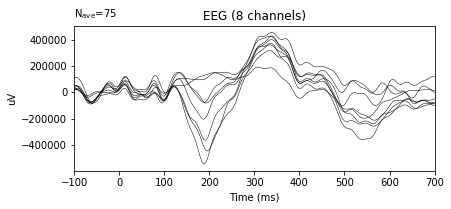

time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning


<ipython-input-1095-25cd1e677c49>:3: DeprecationWarning:

time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning



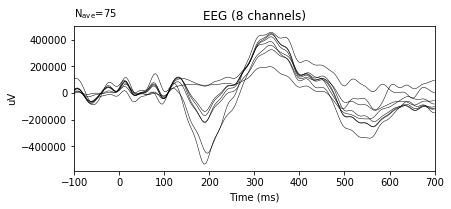

In [1095]:
epochs['1'].average().plot()
plt.show()
new_epochs.average().plot()
plt.show()

Select only components with significant difference from baseline interval

# Simple classification

Creating RawArray with float64 data, n_channels=9, n_times=65282
    Range : 0 ... 65281 =      0.000 ...   261.124 secs
Ready.
The unit for channel(s) Cz, Fz, Oz, P3, P4, Po7, Po8, Pz has changed from NA to V.


<ipython-input-856-90a5503e84bc>:10: RuntimeWarning:

The unit for channel(s) Cz, Fz, Oz, P3, P4, Po7, Po8, Pz has changed from NA to V.



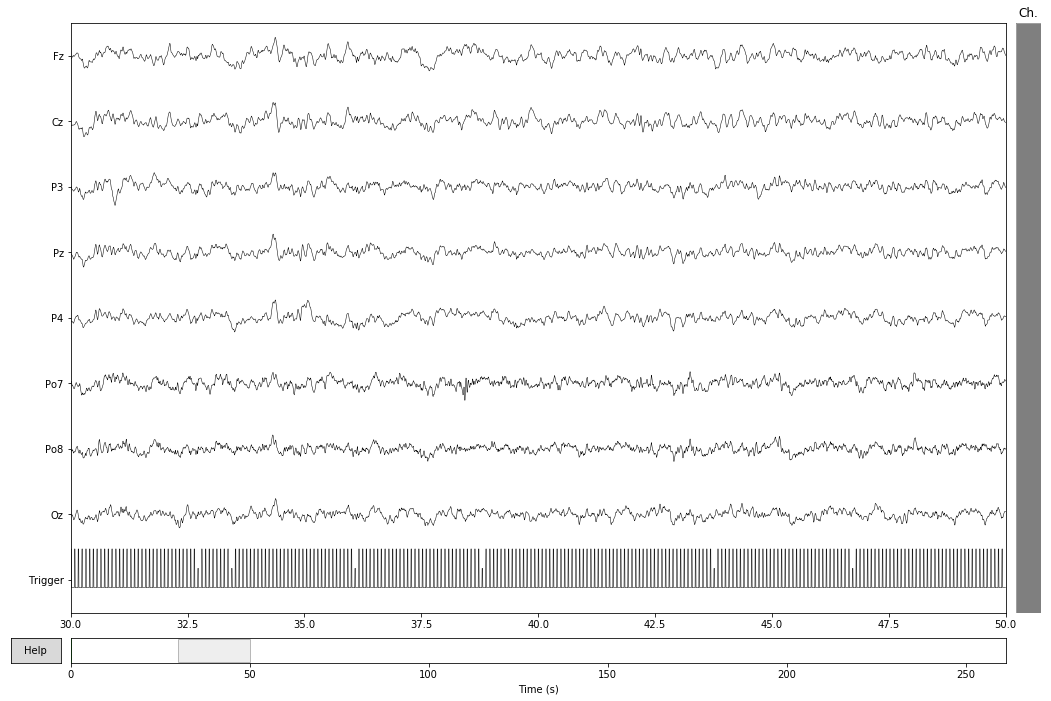

Setting up band-stop filter from 49 - 51 Hz
Filter length of 1651 samples (6.604 sec) selected
Setting up band-pass filter from 0.5 - 30 Hz
l_trans_bandwidth chosen to be 0.5 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 1651 samples (6.604 sec) selected


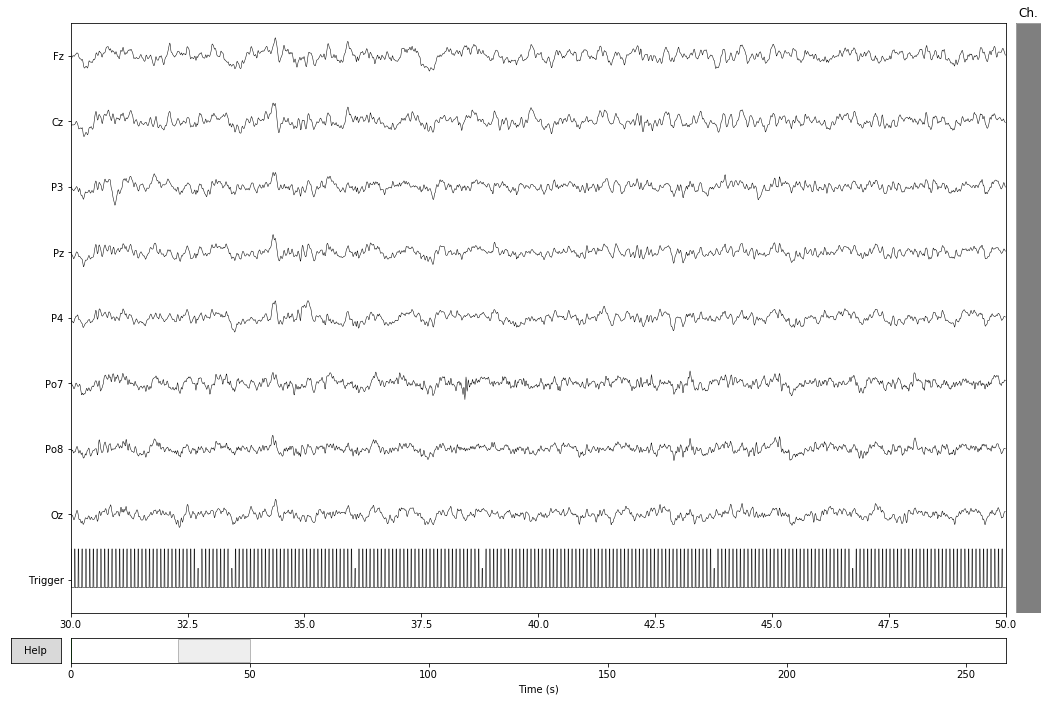

2700 events found
Event IDs: [1 2]
Creating RawArray with float64 data, n_channels=9, n_times=65282
    Range : 0 ... 65281 =      0.000 ...   261.124 secs
Ready.


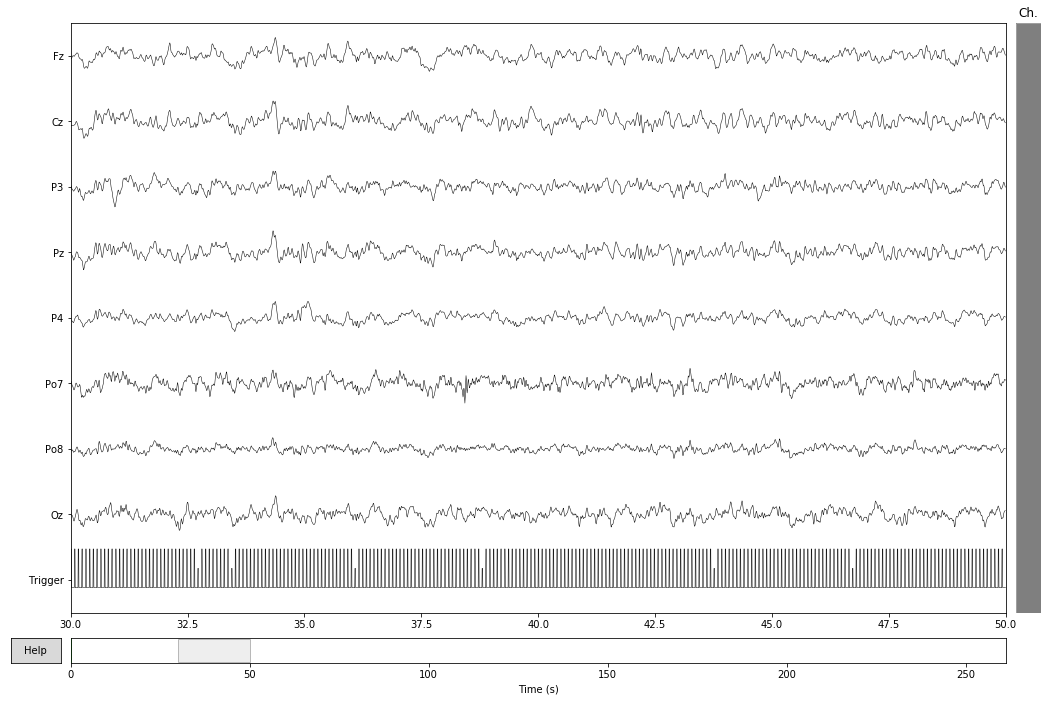

2700 events found
Event IDs: [1 2]
2700 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 2700 events and 201 original time points ...
0 bad epochs dropped
The measurement information indicates a low-pass frequency of 30 Hz. The decim=12 parameter will result in a sampling frequency of 20.8333 Hz, which can cause aliasing artifacts.
Creating RawArray with float64 data, n_channels=9, n_times=65502
    Range : 0 ... 65501 =      0.000 ...   262.004 secs
Ready.
The unit for channel(s) Cz, Fz, Oz, P3, P4, Po7, Po8, Pz has changed from NA to V.


<ipython-input-962-6f50779c34a7>:5: RuntimeWarning:

The measurement information indicates a low-pass frequency of 30 Hz. The decim=12 parameter will result in a sampling frequency of 20.8333 Hz, which can cause aliasing artifacts.

<ipython-input-856-90a5503e84bc>:10: RuntimeWarning:

The unit for channel(s) Cz, Fz, Oz, P3, P4, Po7, Po8, Pz has changed from NA to V.



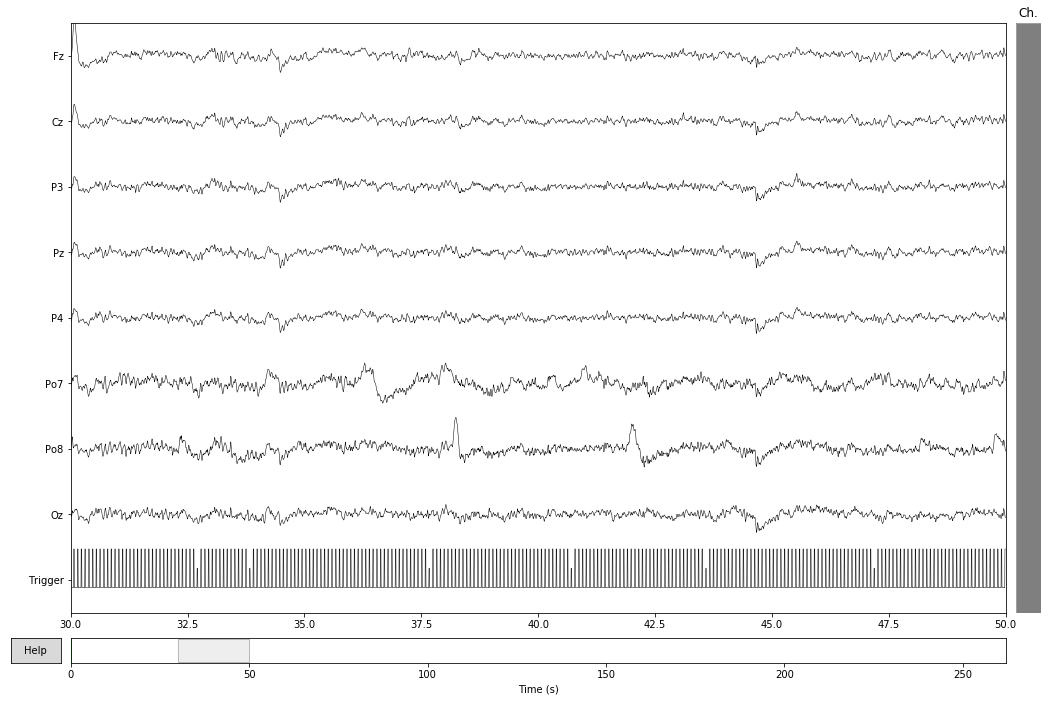

Setting up band-stop filter from 49 - 51 Hz
Filter length of 1651 samples (6.604 sec) selected
Setting up band-pass filter from 0.5 - 30 Hz
l_trans_bandwidth chosen to be 0.5 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 1651 samples (6.604 sec) selected


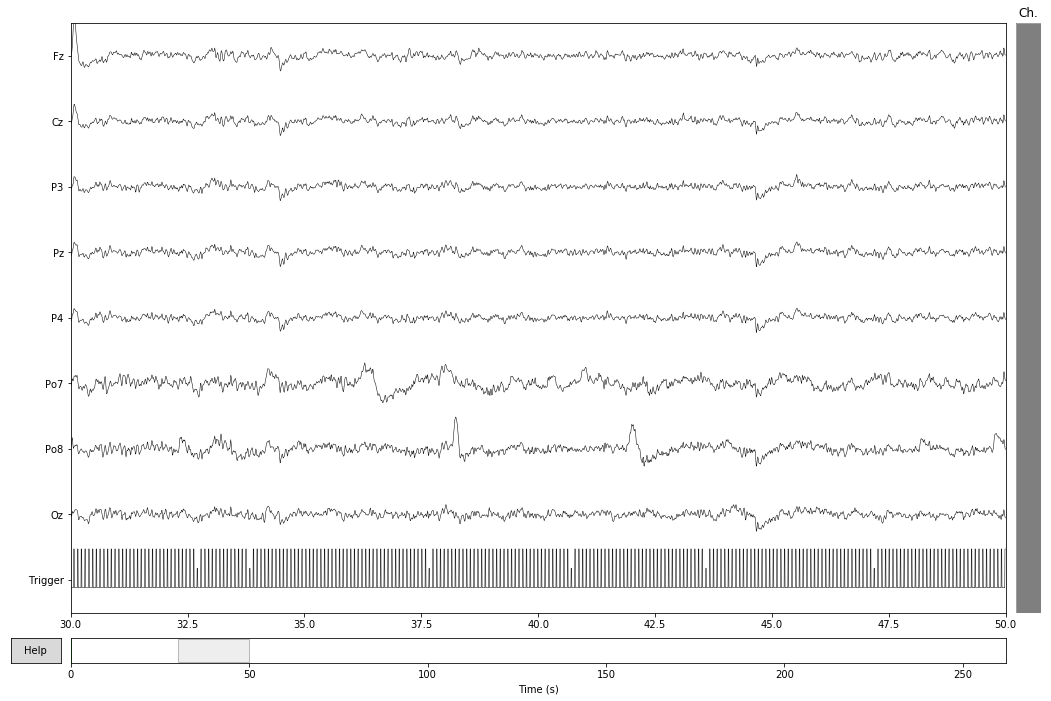

2700 events found
Event IDs: [1 2]
Creating RawArray with float64 data, n_channels=9, n_times=65502
    Range : 0 ... 65501 =      0.000 ...   262.004 secs
Ready.


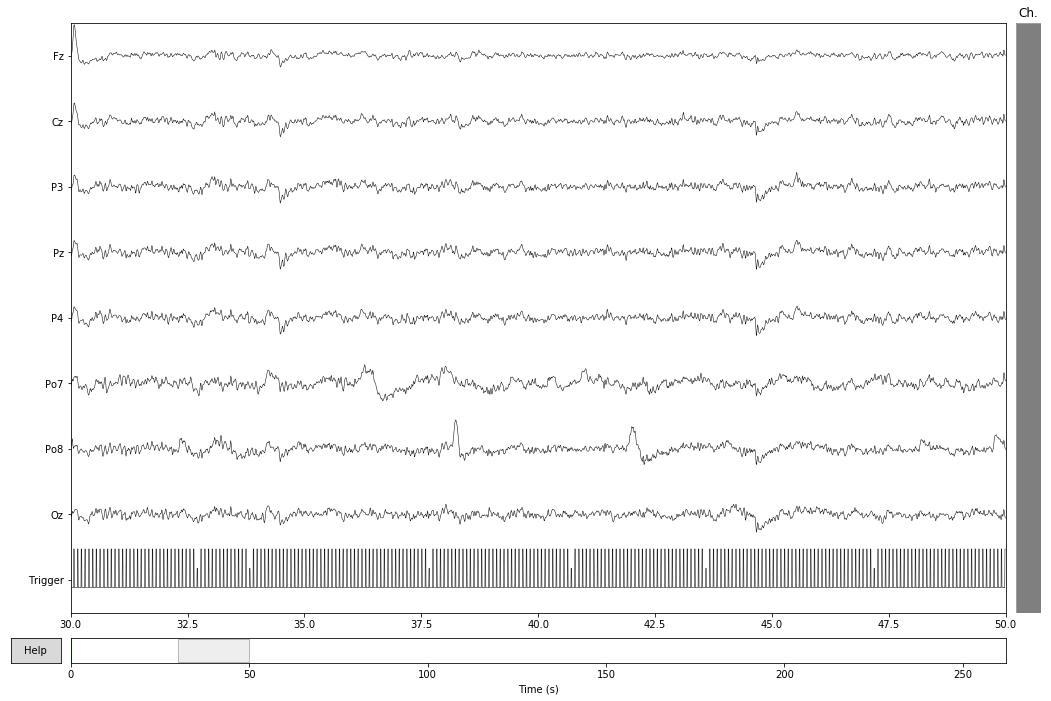

2700 events found
Event IDs: [1 2]
2700 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 2700 events and 201 original time points ...
0 bad epochs dropped
The measurement information indicates a low-pass frequency of 30 Hz. The decim=12 parameter will result in a sampling frequency of 20.8333 Hz, which can cause aliasing artifacts.
Creating RawArray with float64 data, n_channels=9, n_times=61866
    Range : 0 ... 61865 =      0.000 ...   247.460 secs
Ready.
The unit for channel(s) Cz, Fz, Oz, P3, P4, Po7, Po8, Pz has changed from NA to V.


<ipython-input-962-6f50779c34a7>:5: RuntimeWarning:

The measurement information indicates a low-pass frequency of 30 Hz. The decim=12 parameter will result in a sampling frequency of 20.8333 Hz, which can cause aliasing artifacts.

<ipython-input-856-90a5503e84bc>:10: RuntimeWarning:

The unit for channel(s) Cz, Fz, Oz, P3, P4, Po7, Po8, Pz has changed from NA to V.



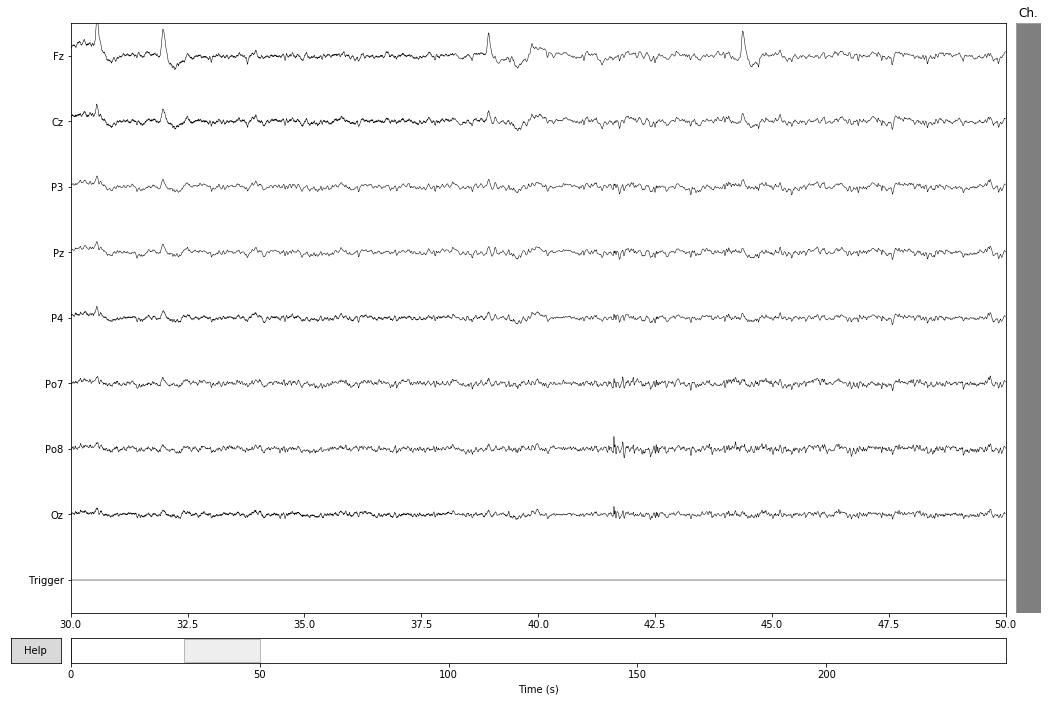

Setting up band-stop filter from 49 - 51 Hz
Filter length of 1651 samples (6.604 sec) selected
Setting up band-pass filter from 0.5 - 30 Hz
l_trans_bandwidth chosen to be 0.5 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 1651 samples (6.604 sec) selected


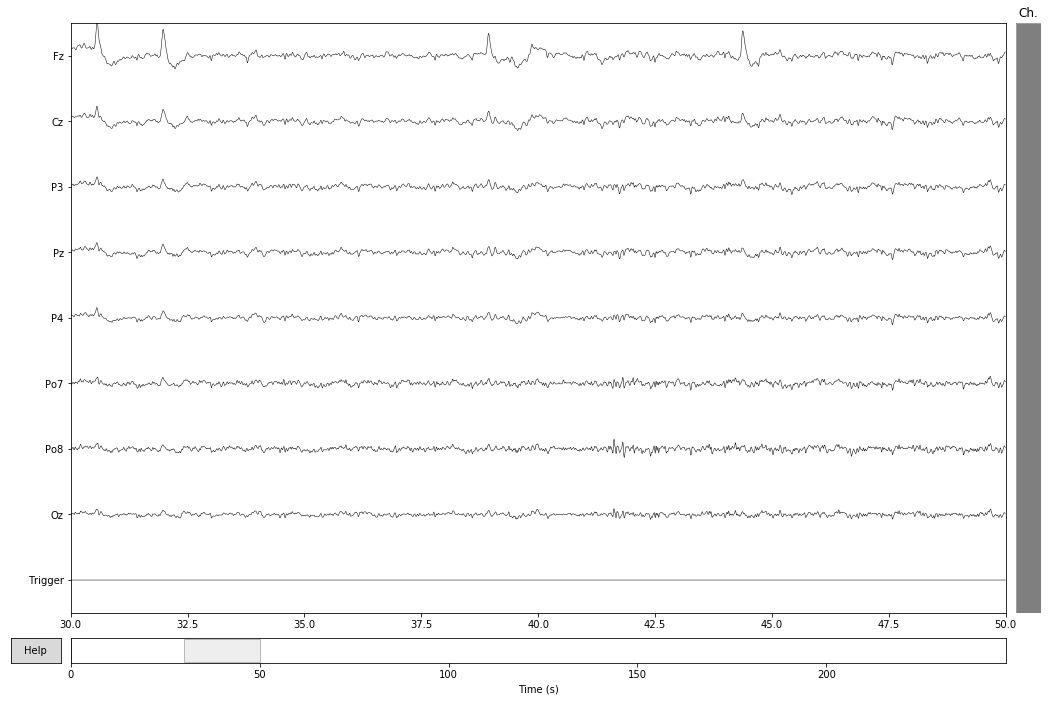

900 events found
Event IDs: [1 2]
Creating RawArray with float64 data, n_channels=9, n_times=61866
    Range : 0 ... 61865 =      0.000 ...   247.460 secs
Ready.


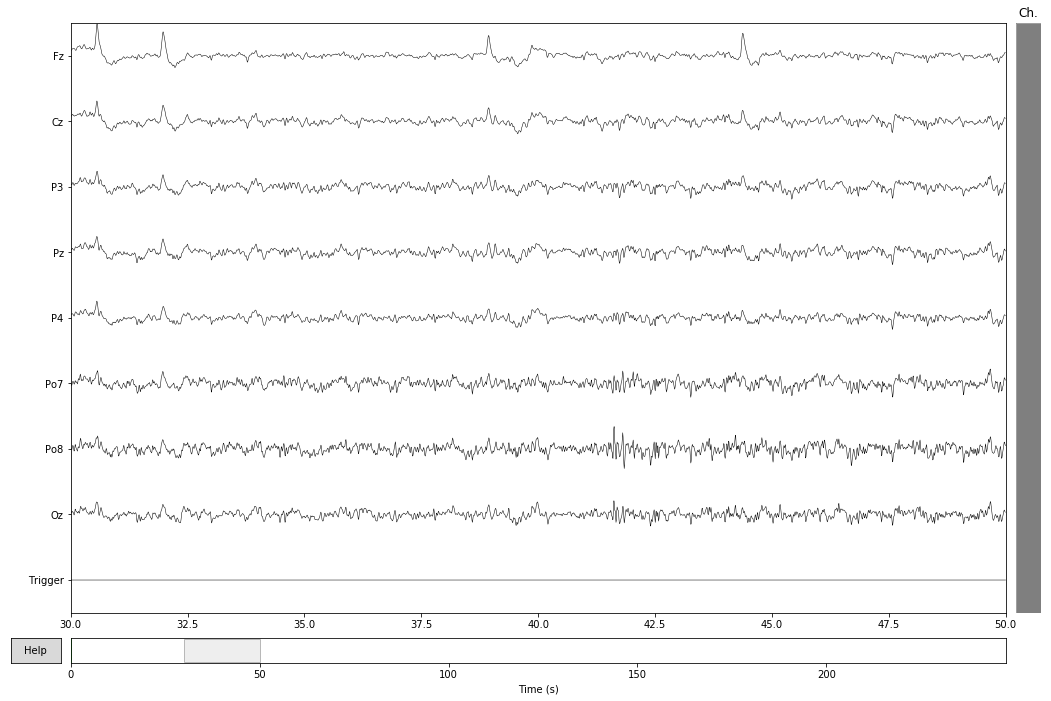

900 events found
Event IDs: [1 2]
900 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 900 events and 201 original time points ...
0 bad epochs dropped
The measurement information indicates a low-pass frequency of 30 Hz. The decim=12 parameter will result in a sampling frequency of 20.8333 Hz, which can cause aliasing artifacts.
Creating RawArray with float64 data, n_channels=9, n_times=48901
    Range : 0 ... 48900 =      0.000 ...   195.600 secs
Ready.
The unit for channel(s) Cz, Fz, Oz, P3, P4, Po7, Po8, Pz has changed from NA to V.


<ipython-input-962-6f50779c34a7>:5: RuntimeWarning:

The measurement information indicates a low-pass frequency of 30 Hz. The decim=12 parameter will result in a sampling frequency of 20.8333 Hz, which can cause aliasing artifacts.

<ipython-input-856-90a5503e84bc>:10: RuntimeWarning:

The unit for channel(s) Cz, Fz, Oz, P3, P4, Po7, Po8, Pz has changed from NA to V.



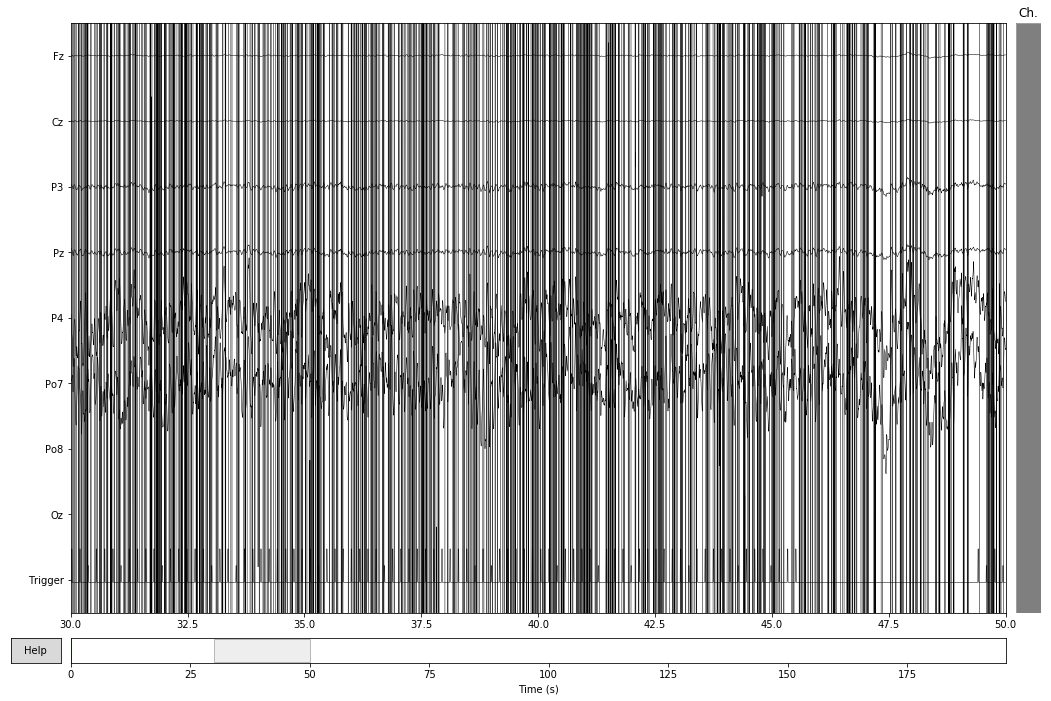

Setting up band-stop filter from 49 - 51 Hz
Filter length of 1651 samples (6.604 sec) selected
Setting up band-pass filter from 0.5 - 30 Hz
l_trans_bandwidth chosen to be 0.5 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 1651 samples (6.604 sec) selected


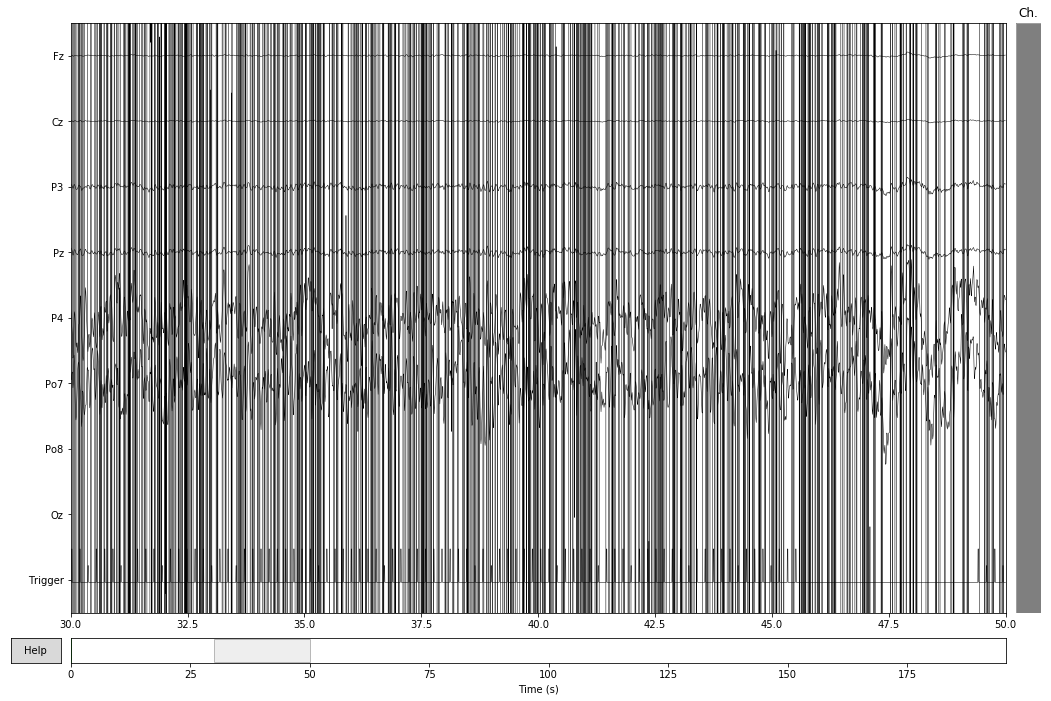

900 events found
Event IDs: [1 2]
Creating RawArray with float64 data, n_channels=9, n_times=48901
    Range : 0 ... 48900 =      0.000 ...   195.600 secs
Ready.


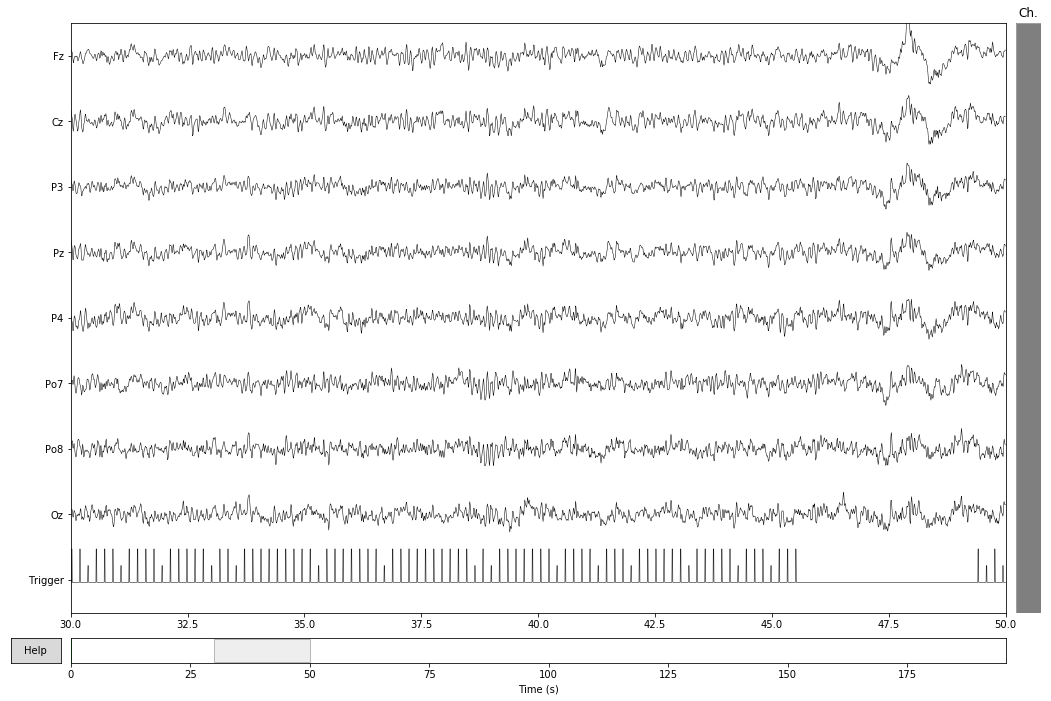

900 events found
Event IDs: [1 2]
900 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 900 events and 201 original time points ...
0 bad epochs dropped
The measurement information indicates a low-pass frequency of 30 Hz. The decim=12 parameter will result in a sampling frequency of 20.8333 Hz, which can cause aliasing artifacts.
Creating RawArray with float64 data, n_channels=9, n_times=58682
    Range : 0 ... 58681 =      0.000 ...   234.724 secs
Ready.
The unit for channel(s) Cz, Fz, Oz, P3, P4, Po7, Po8, Pz has changed from NA to V.


<ipython-input-962-6f50779c34a7>:5: RuntimeWarning:

The measurement information indicates a low-pass frequency of 30 Hz. The decim=12 parameter will result in a sampling frequency of 20.8333 Hz, which can cause aliasing artifacts.

<ipython-input-856-90a5503e84bc>:10: RuntimeWarning:

The unit for channel(s) Cz, Fz, Oz, P3, P4, Po7, Po8, Pz has changed from NA to V.



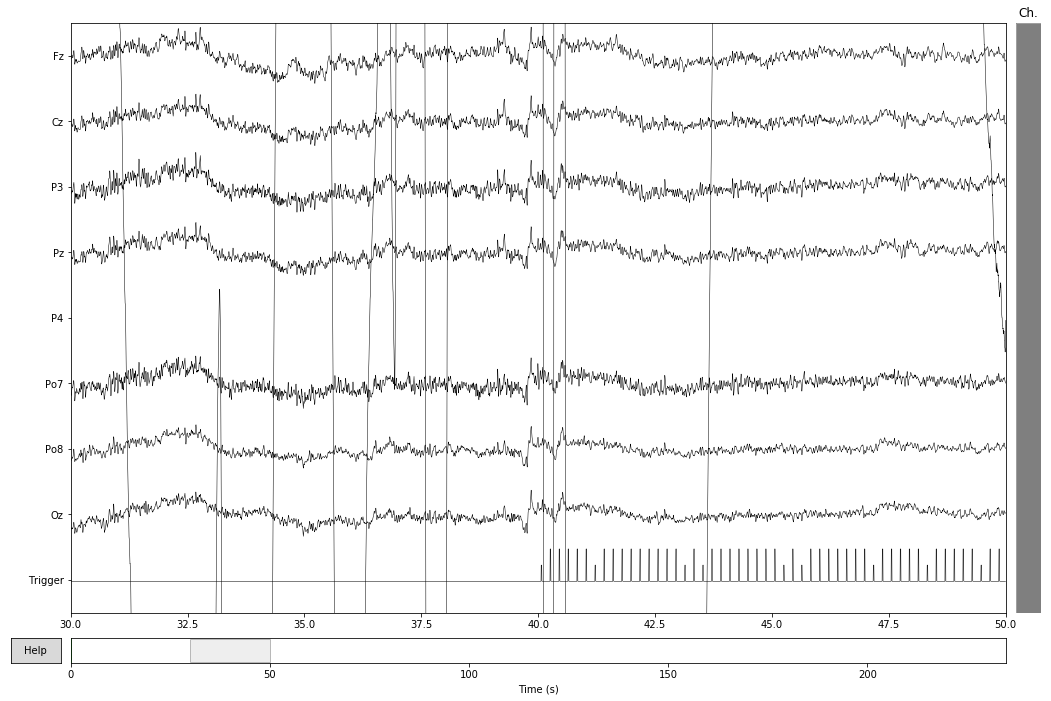

Setting up band-stop filter from 49 - 51 Hz
Filter length of 1651 samples (6.604 sec) selected
Setting up band-pass filter from 0.5 - 30 Hz
l_trans_bandwidth chosen to be 0.5 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 1651 samples (6.604 sec) selected


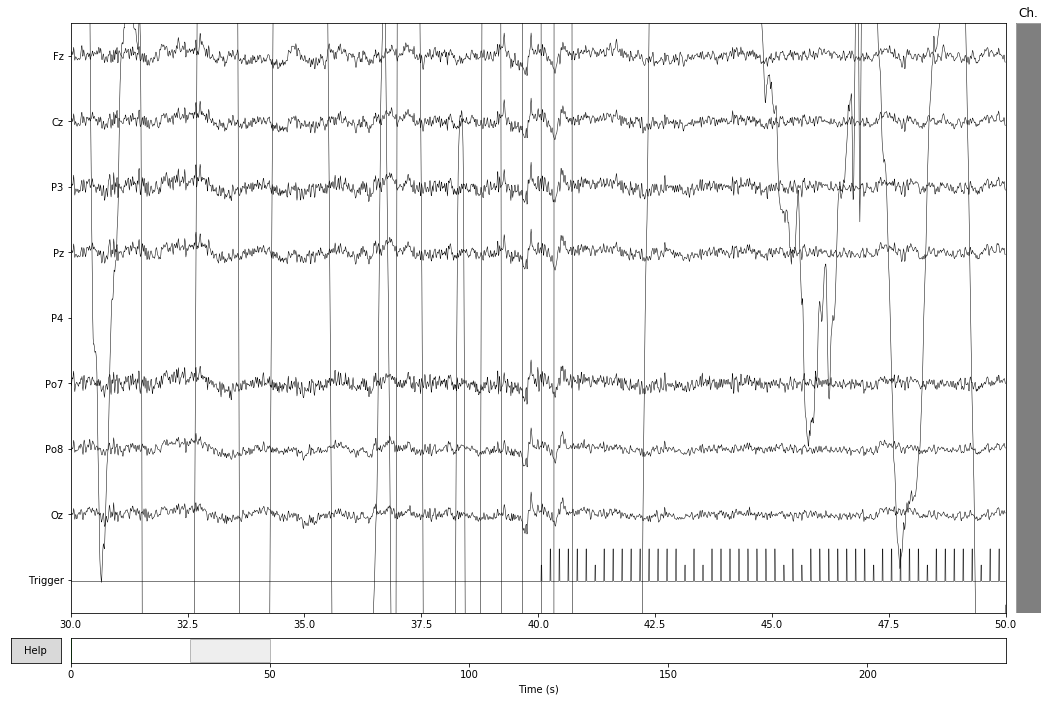

900 events found
Event IDs: [1 2]
Creating RawArray with float64 data, n_channels=9, n_times=58682
    Range : 0 ... 58681 =      0.000 ...   234.724 secs
Ready.


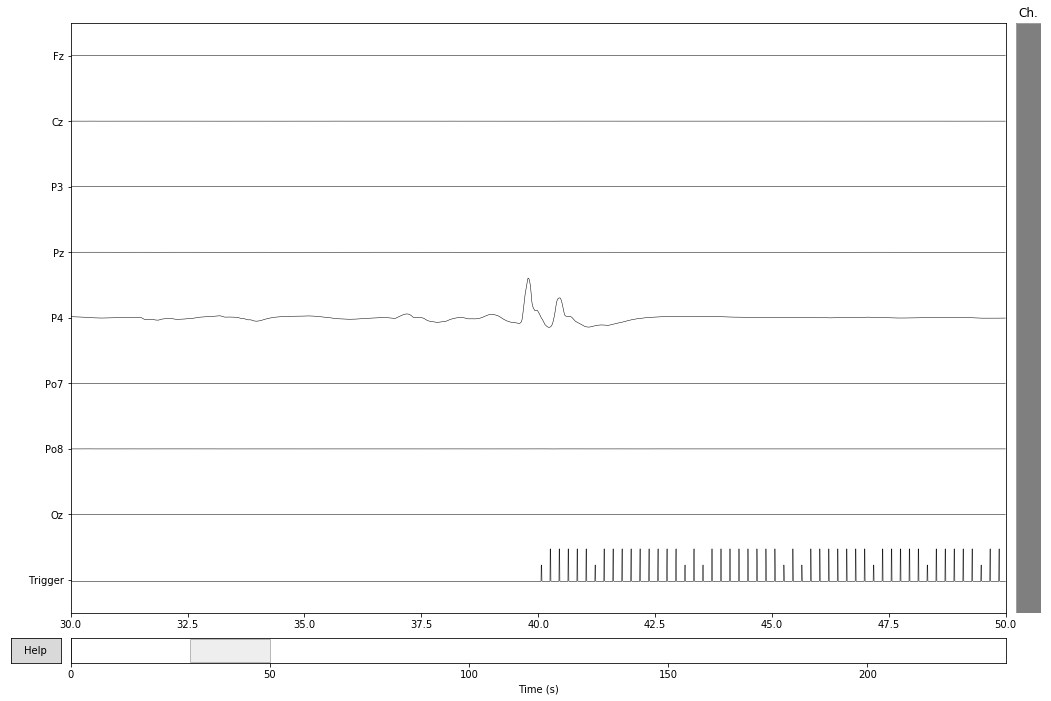

900 events found
Event IDs: [1 2]
900 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 900 events and 201 original time points ...
0 bad epochs dropped
The measurement information indicates a low-pass frequency of 30 Hz. The decim=12 parameter will result in a sampling frequency of 20.8333 Hz, which can cause aliasing artifacts.
Creating RawArray with float64 data, n_channels=9, n_times=25327
    Range : 0 ... 25326 =      0.000 ...   101.304 secs
Ready.
The unit for channel(s) Cz, Fz, Oz, P3, P4, Po7, Po8, Pz has changed from NA to V.


<ipython-input-962-6f50779c34a7>:5: RuntimeWarning:

The measurement information indicates a low-pass frequency of 30 Hz. The decim=12 parameter will result in a sampling frequency of 20.8333 Hz, which can cause aliasing artifacts.

<ipython-input-856-90a5503e84bc>:10: RuntimeWarning:

The unit for channel(s) Cz, Fz, Oz, P3, P4, Po7, Po8, Pz has changed from NA to V.



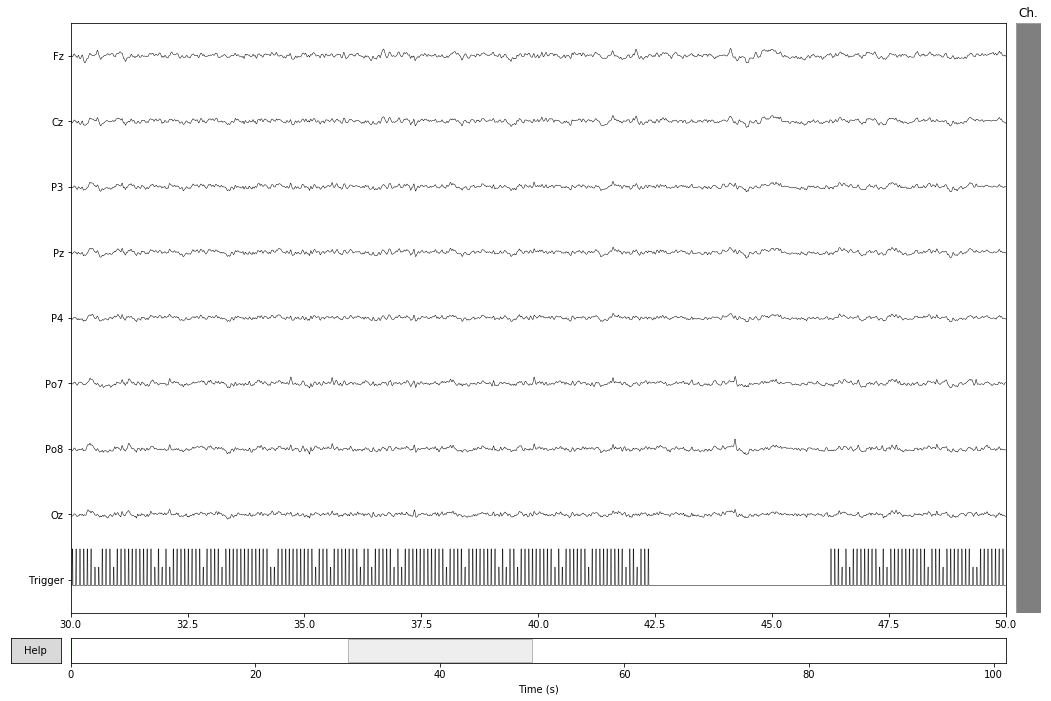

Setting up band-stop filter from 49 - 51 Hz
Filter length of 1651 samples (6.604 sec) selected
Setting up band-pass filter from 0.5 - 30 Hz
l_trans_bandwidth chosen to be 0.5 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 1651 samples (6.604 sec) selected


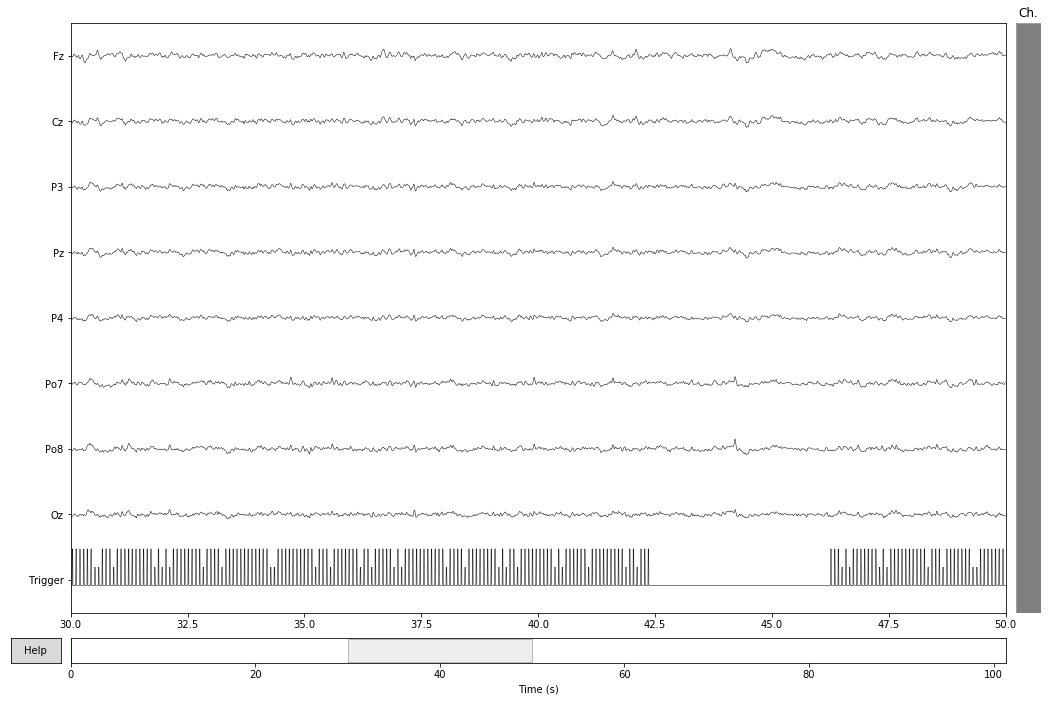

900 events found
Event IDs: [1 2]
Creating RawArray with float64 data, n_channels=9, n_times=25327
    Range : 0 ... 25326 =      0.000 ...   101.304 secs
Ready.


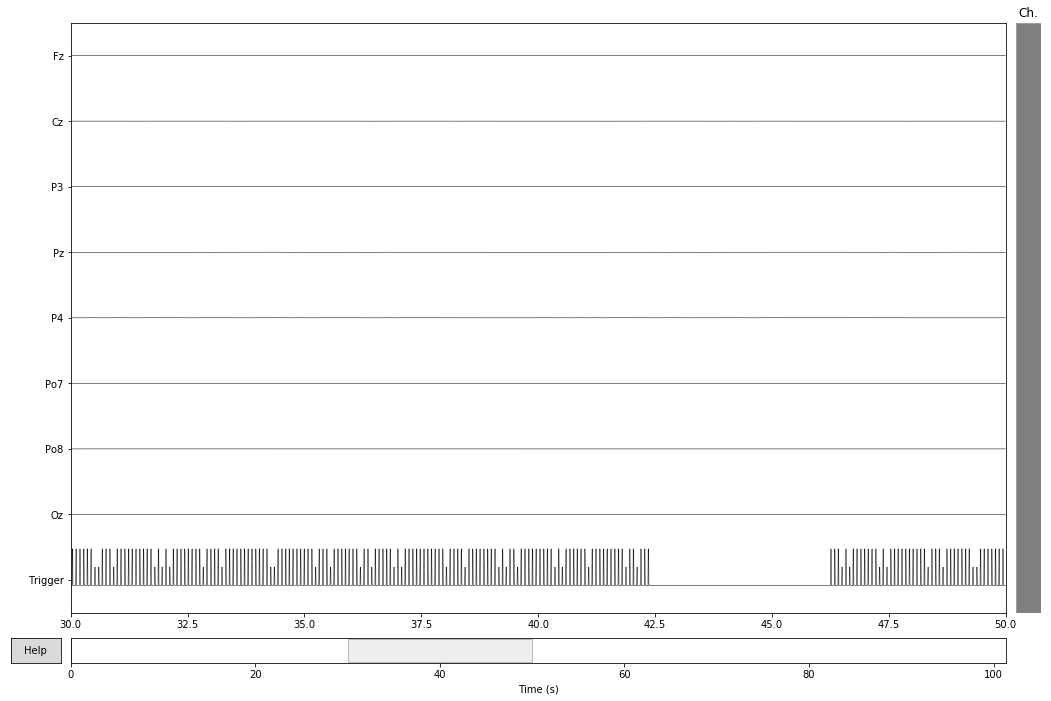

900 events found
Event IDs: [1 2]
900 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 900 events and 201 original time points ...
0 bad epochs dropped
The measurement information indicates a low-pass frequency of 30 Hz. The decim=12 parameter will result in a sampling frequency of 20.8333 Hz, which can cause aliasing artifacts.
Creating RawArray with float64 data, n_channels=9, n_times=28806
    Range : 0 ... 28805 =      0.000 ...   115.220 secs
Ready.
The unit for channel(s) Cz, Fz, Oz, P3, P4, Po7, Po8, Pz has changed from NA to V.


<ipython-input-962-6f50779c34a7>:5: RuntimeWarning:

The measurement information indicates a low-pass frequency of 30 Hz. The decim=12 parameter will result in a sampling frequency of 20.8333 Hz, which can cause aliasing artifacts.

<ipython-input-856-90a5503e84bc>:10: RuntimeWarning:

The unit for channel(s) Cz, Fz, Oz, P3, P4, Po7, Po8, Pz has changed from NA to V.



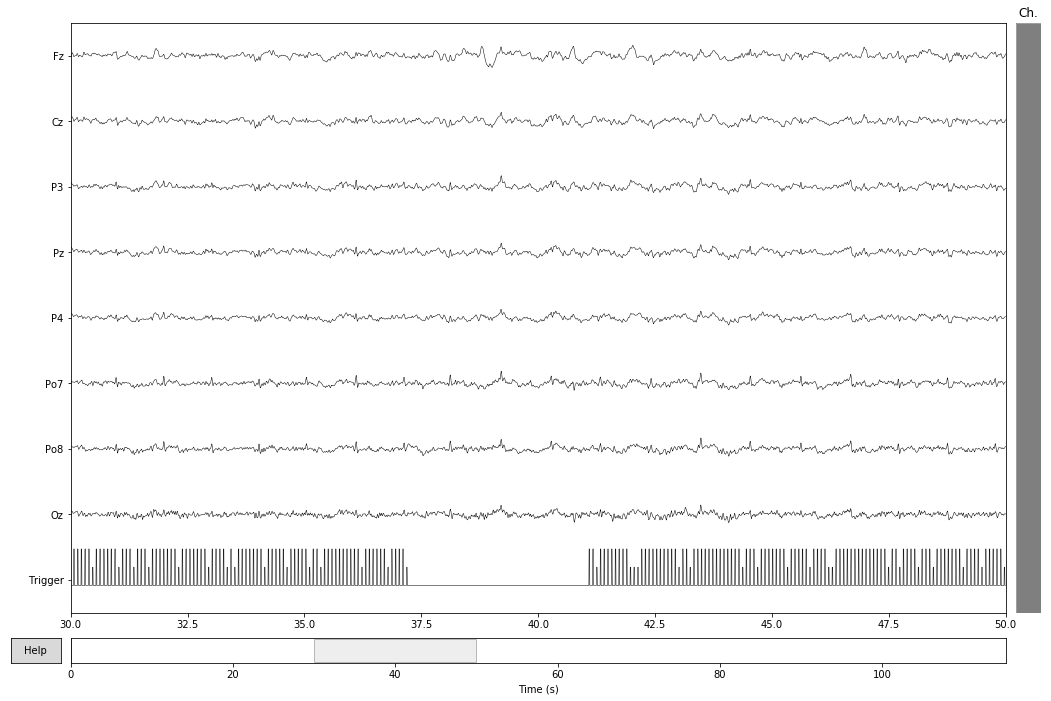

Setting up band-stop filter from 49 - 51 Hz
Filter length of 1651 samples (6.604 sec) selected
Setting up band-pass filter from 0.5 - 30 Hz
l_trans_bandwidth chosen to be 0.5 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 1651 samples (6.604 sec) selected


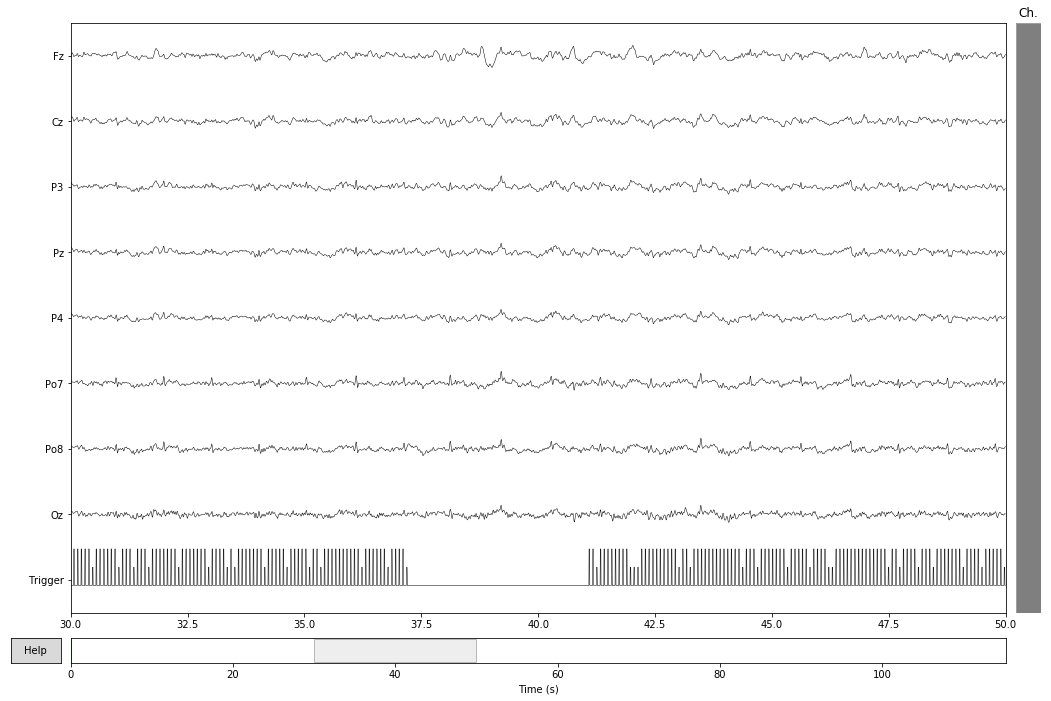

900 events found
Event IDs: [1 2]
Creating RawArray with float64 data, n_channels=9, n_times=28806
    Range : 0 ... 28805 =      0.000 ...   115.220 secs
Ready.


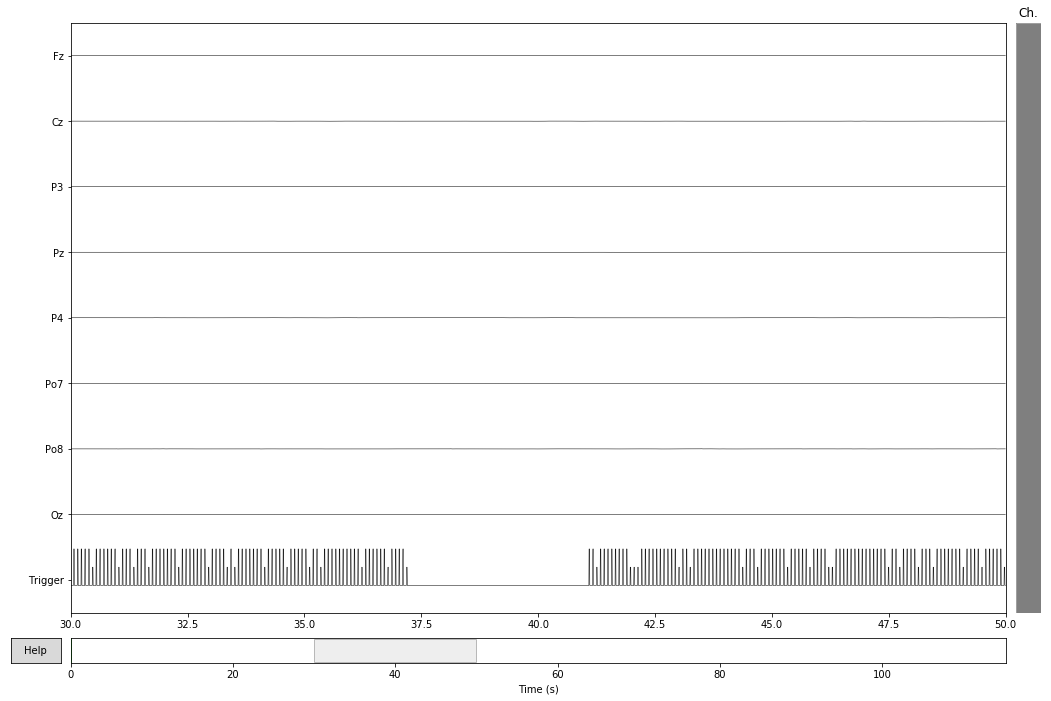

900 events found
Event IDs: [1 2]
900 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 900 events and 201 original time points ...
0 bad epochs dropped
The measurement information indicates a low-pass frequency of 30 Hz. The decim=12 parameter will result in a sampling frequency of 20.8333 Hz, which can cause aliasing artifacts.
Creating RawArray with float64 data, n_channels=9, n_times=28901
    Range : 0 ... 28900 =      0.000 ...   115.600 secs
Ready.
The unit for channel(s) Cz, Fz, Oz, P3, P4, Po7, Po8, Pz has changed from NA to V.


<ipython-input-962-6f50779c34a7>:5: RuntimeWarning:

The measurement information indicates a low-pass frequency of 30 Hz. The decim=12 parameter will result in a sampling frequency of 20.8333 Hz, which can cause aliasing artifacts.

<ipython-input-856-90a5503e84bc>:10: RuntimeWarning:

The unit for channel(s) Cz, Fz, Oz, P3, P4, Po7, Po8, Pz has changed from NA to V.



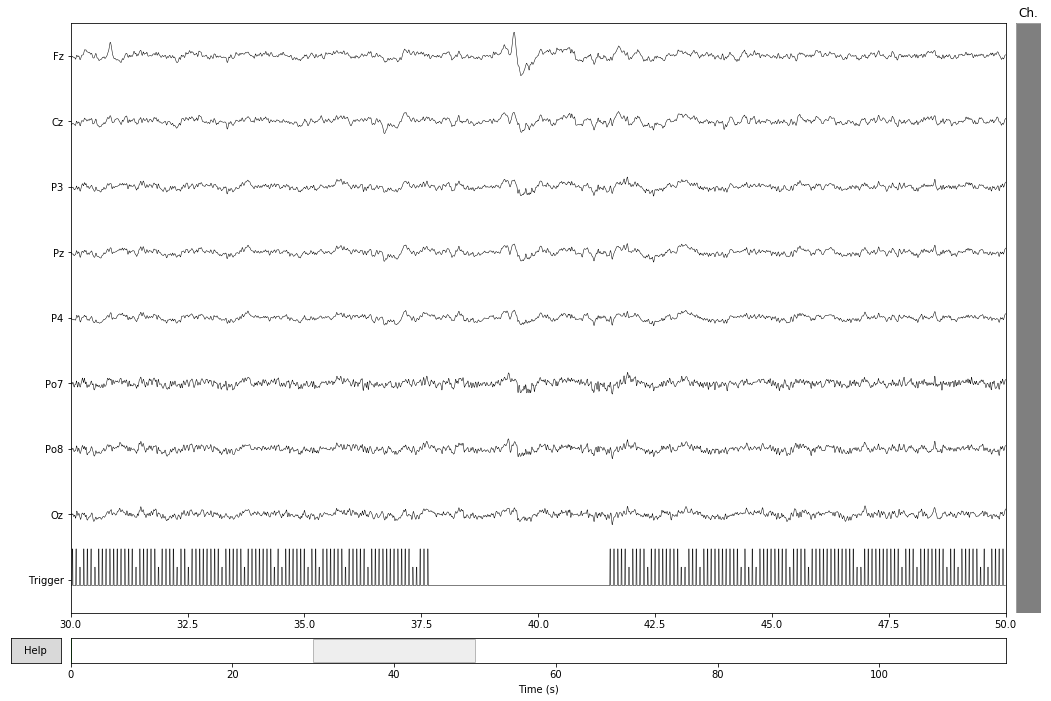

Setting up band-stop filter from 49 - 51 Hz
Filter length of 1651 samples (6.604 sec) selected
Setting up band-pass filter from 0.5 - 30 Hz
l_trans_bandwidth chosen to be 0.5 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 1651 samples (6.604 sec) selected


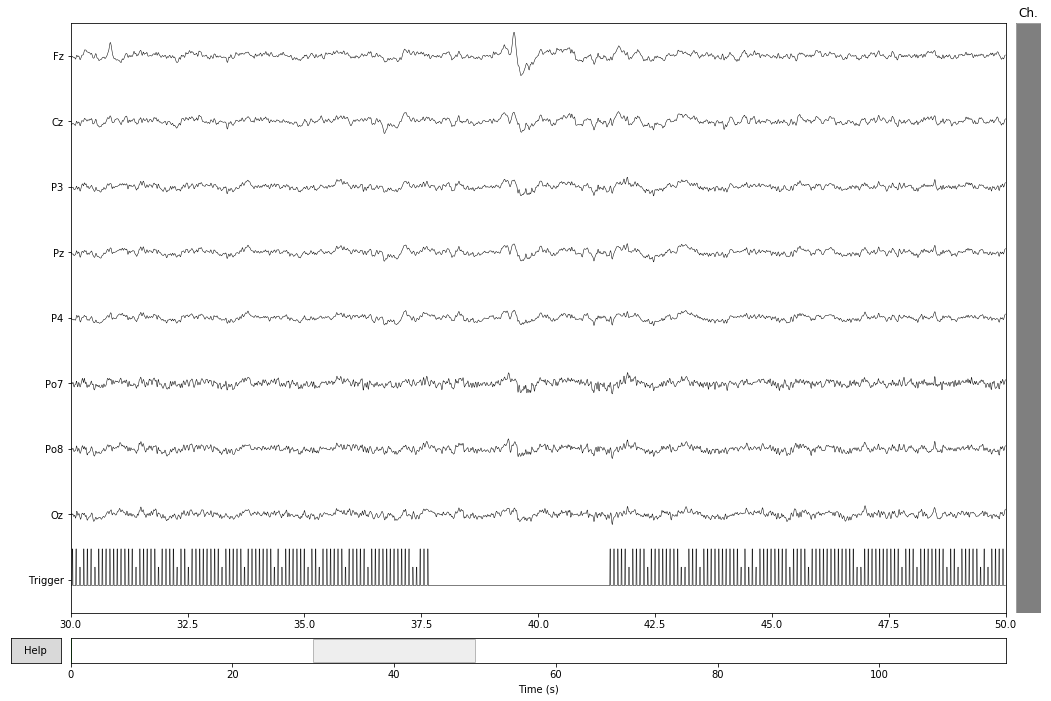

900 events found
Event IDs: [1 2]
Creating RawArray with float64 data, n_channels=9, n_times=28901
    Range : 0 ... 28900 =      0.000 ...   115.600 secs
Ready.


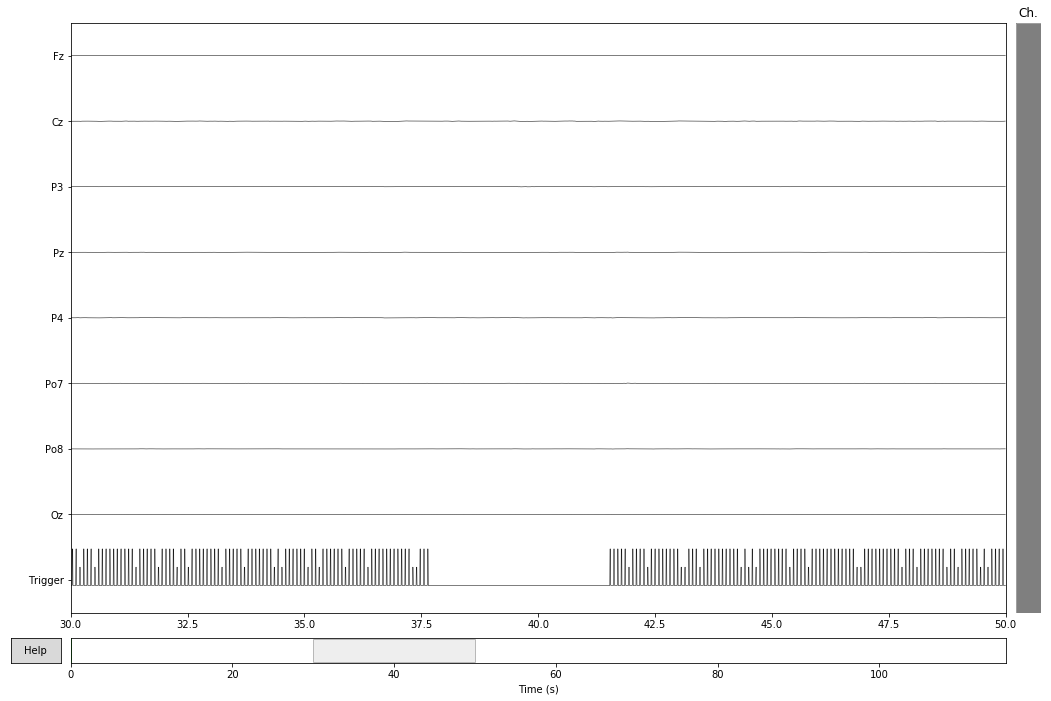

900 events found
Event IDs: [1 2]
900 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 900 events and 201 original time points ...
0 bad epochs dropped
The measurement information indicates a low-pass frequency of 30 Hz. The decim=12 parameter will result in a sampling frequency of 20.8333 Hz, which can cause aliasing artifacts.
Creating RawArray with float64 data, n_channels=9, n_times=27940
    Range : 0 ... 27939 =      0.000 ...   111.756 secs
Ready.
The unit for channel(s) Cz, Fz, Oz, P3, P4, Po7, Po8, Pz has changed from NA to V.


<ipython-input-962-6f50779c34a7>:5: RuntimeWarning:

The measurement information indicates a low-pass frequency of 30 Hz. The decim=12 parameter will result in a sampling frequency of 20.8333 Hz, which can cause aliasing artifacts.

<ipython-input-856-90a5503e84bc>:10: RuntimeWarning:

The unit for channel(s) Cz, Fz, Oz, P3, P4, Po7, Po8, Pz has changed from NA to V.



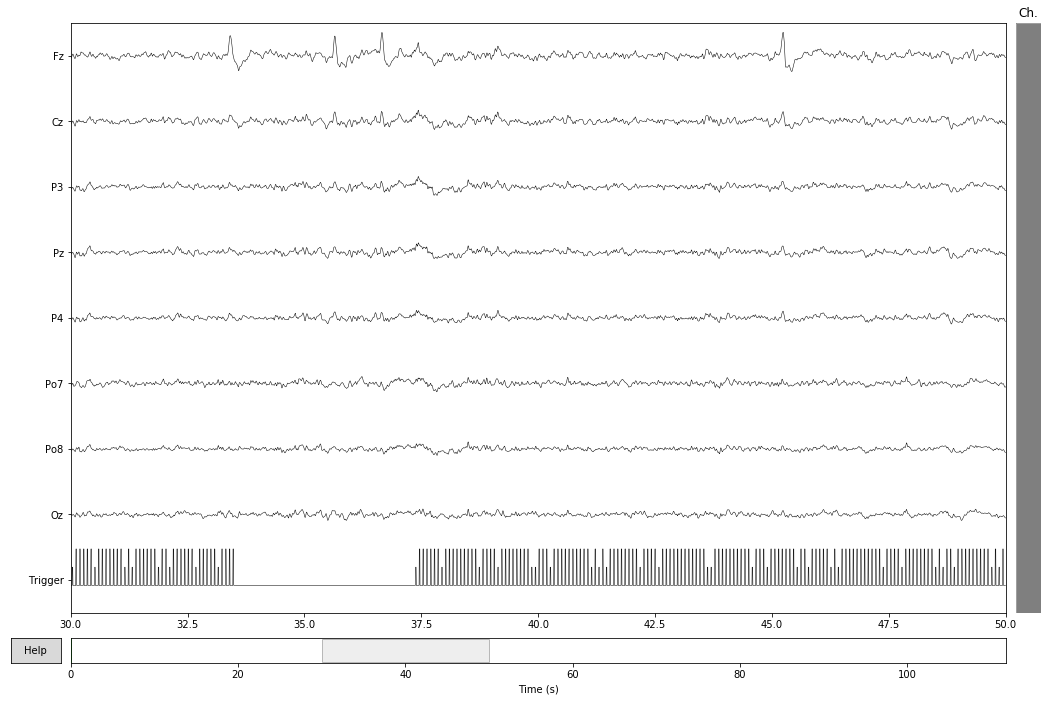

Setting up band-stop filter from 49 - 51 Hz
Filter length of 1651 samples (6.604 sec) selected
Setting up band-pass filter from 0.5 - 30 Hz
l_trans_bandwidth chosen to be 0.5 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 1651 samples (6.604 sec) selected


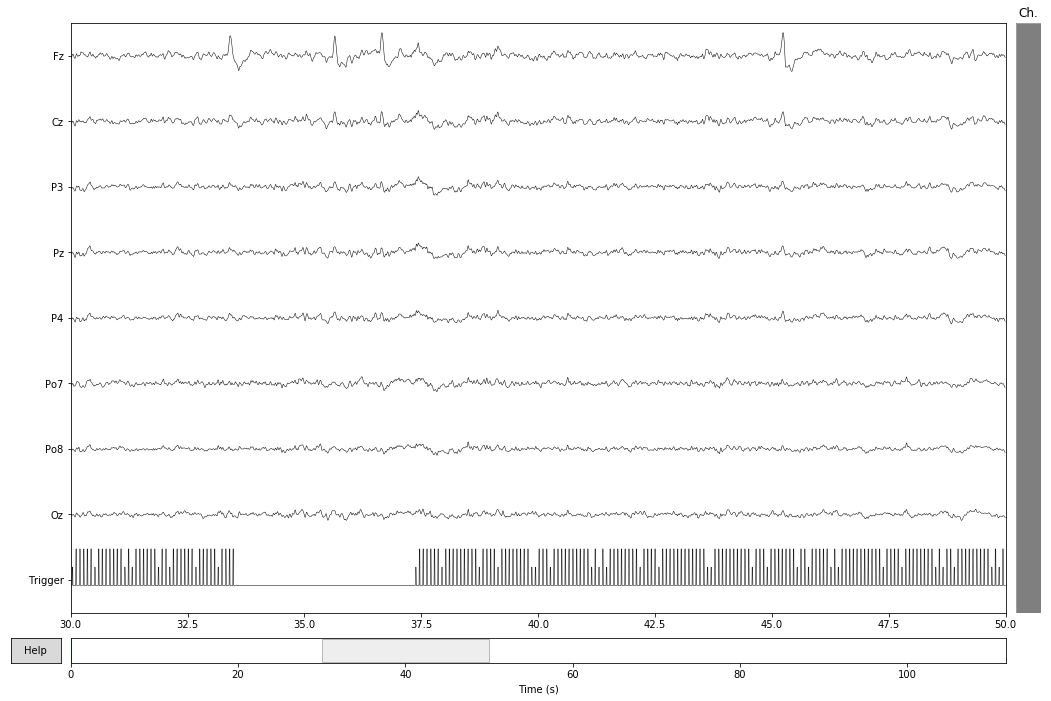

900 events found
Event IDs: [1 2]
Creating RawArray with float64 data, n_channels=9, n_times=27940
    Range : 0 ... 27939 =      0.000 ...   111.756 secs
Ready.


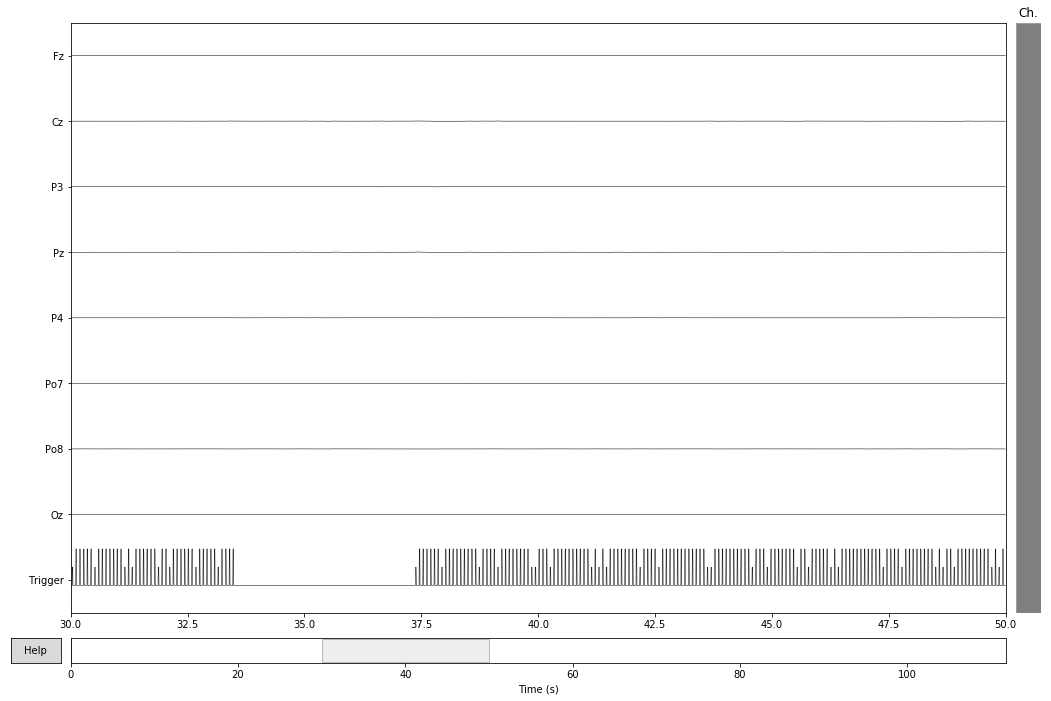

900 events found
Event IDs: [1 2]
900 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 900 events and 201 original time points ...
0 bad epochs dropped
The measurement information indicates a low-pass frequency of 30 Hz. The decim=12 parameter will result in a sampling frequency of 20.8333 Hz, which can cause aliasing artifacts.
Creating RawArray with float64 data, n_channels=9, n_times=25587
    Range : 0 ... 25586 =      0.000 ...   102.344 secs
Ready.
The unit for channel(s) Cz, Fz, Oz, P3, P4, Po7, Po8, Pz has changed from NA to V.


<ipython-input-962-6f50779c34a7>:5: RuntimeWarning:

The measurement information indicates a low-pass frequency of 30 Hz. The decim=12 parameter will result in a sampling frequency of 20.8333 Hz, which can cause aliasing artifacts.

<ipython-input-856-90a5503e84bc>:10: RuntimeWarning:

The unit for channel(s) Cz, Fz, Oz, P3, P4, Po7, Po8, Pz has changed from NA to V.



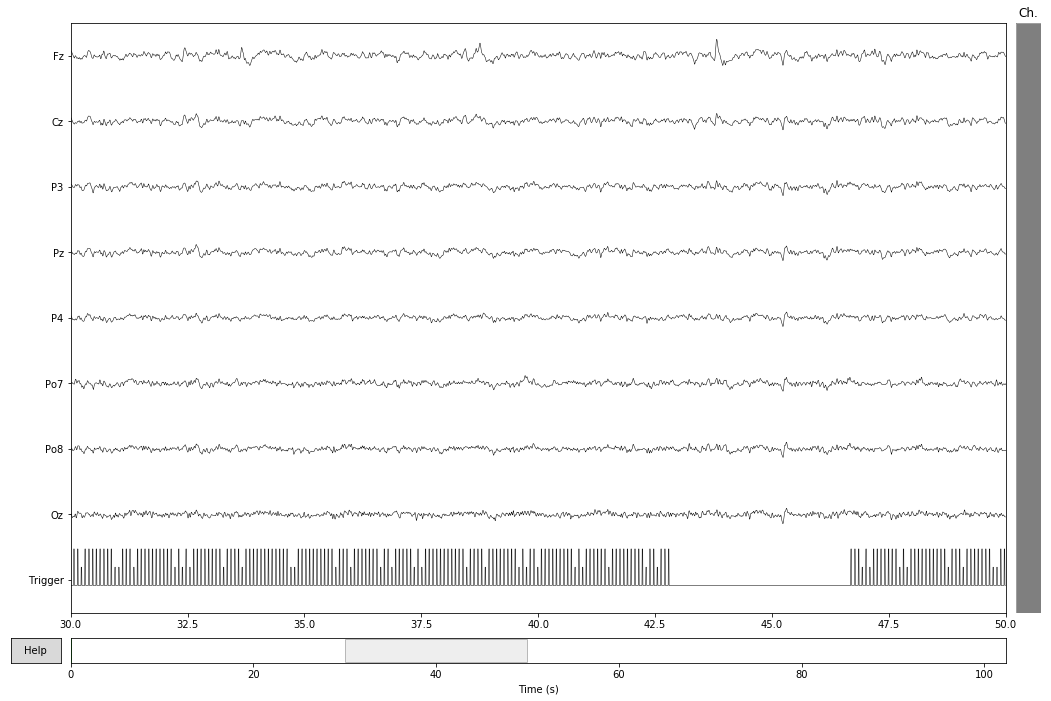

Setting up band-stop filter from 49 - 51 Hz
Filter length of 1651 samples (6.604 sec) selected
Setting up band-pass filter from 0.5 - 30 Hz
l_trans_bandwidth chosen to be 0.5 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 1651 samples (6.604 sec) selected


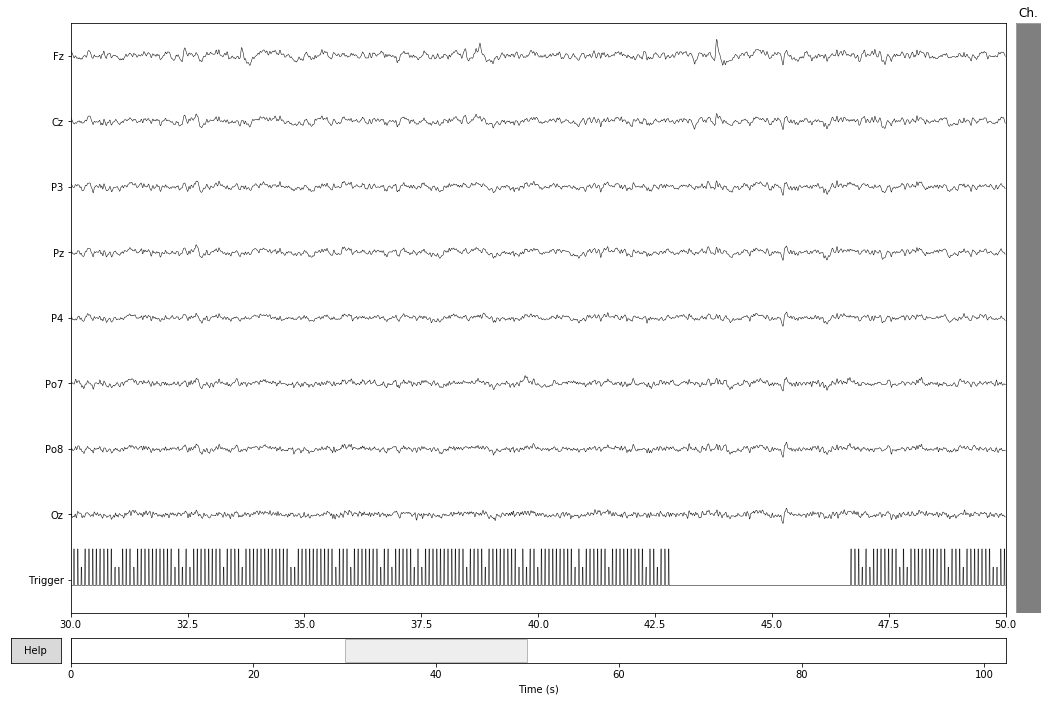

900 events found
Event IDs: [1 2]
Creating RawArray with float64 data, n_channels=9, n_times=25587
    Range : 0 ... 25586 =      0.000 ...   102.344 secs
Ready.


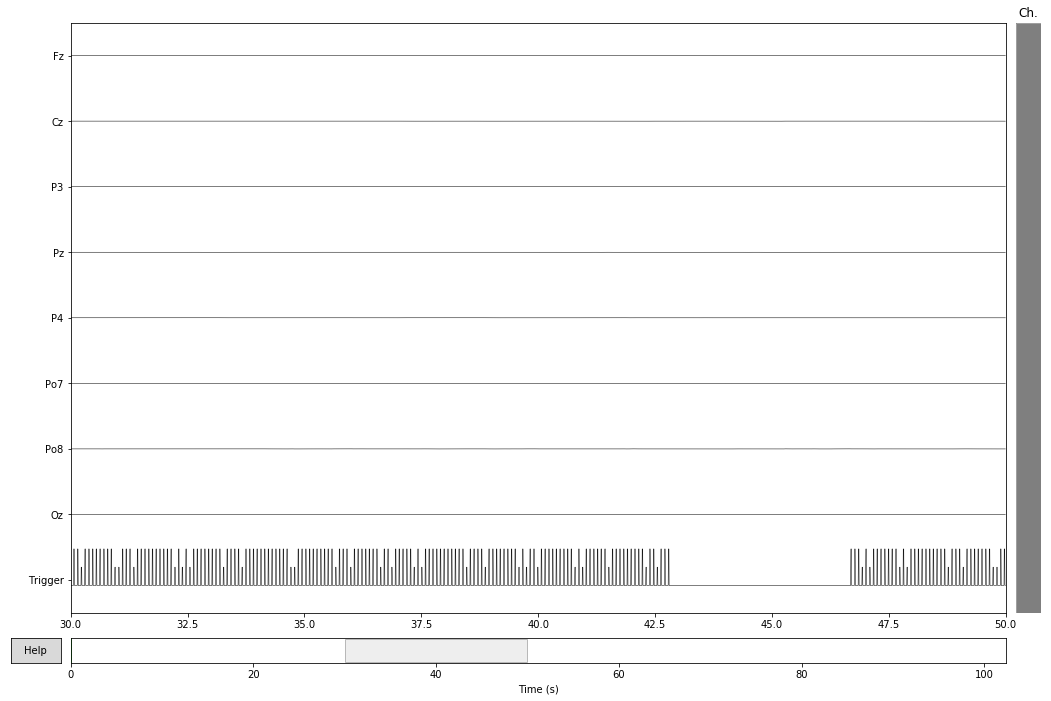

900 events found
Event IDs: [1 2]
900 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 900 events and 201 original time points ...
0 bad epochs dropped
The measurement information indicates a low-pass frequency of 30 Hz. The decim=12 parameter will result in a sampling frequency of 20.8333 Hz, which can cause aliasing artifacts.


<ipython-input-962-6f50779c34a7>:5: RuntimeWarning:

The measurement information indicates a low-pass frequency of 30 Hz. The decim=12 parameter will result in a sampling frequency of 20.8333 Hz, which can cause aliasing artifacts.



In [962]:
all_epochs = []

for i in range(1, 11):
    epochs = process_signal(i)
    epochs = epochs.decimate(12)
    all_epochs += [epochs]

In [963]:
def get_dataset(epochs, class_label):
    events_X = epochs.get_data()
    events_X = events_X.reshape(events_X.shape[0], -1)
    
    events_y = [class_label] * events_X.shape[0]
    
    return events_X, events_y

In [984]:
i = 7

In [985]:
all_events_X = []
all_events_y = []

for epochs in all_epochs[i:i + 1]:
    positive_events_X, positive_events_y = get_dataset(epochs['1'], 1)
    negative_events_X, negative_events_y = get_dataset(epochs['2'], 0)
    
    all_events_X += [positive_events_X] + [negative_events_X]
    all_events_y += positive_events_y + negative_events_y

In [986]:
merged_events_X = np.vstack(all_events_X)

In [987]:
def get_metric(model, grid, scoring="accuracy", return_model = False):
    search = GridSearchCV(model, grid, cv=3, scoring=scoring)
    search.fit(merged_events_X, all_events_y)
    if return_model:
        return search.best_estimator_
    return search.best_score_

In [988]:
grid = {
    "solver": ['svd']
}
model = LDA()
get_metric(model, grid, scoring= "roc_auc")

0.8686133333333332